#IMPORTING LIBRARIES

In [2]:
# !pip install opendatasets
# import opendatasets as od

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset_url = "https://www.kaggle.com/datasets/forderation/breakhis-400x"
# # dataset_url = "https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset"
# od.download(dataset_url)

# #kandiboina
# #d7e4c117ff4be02240010a46985783df


In [3]:
import json
import math
import os

from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, Conv2D, Flatten, BatchNormalization

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile,VGG16
# from tensorflow.keras.applications import DenseNet201,VGG16
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import gc
import itertools
from tqdm import tqdm
from PIL import Image
from functools import partial
from collections import Counter

%matplotlib inline

#LOADING AND PREPROCESSING


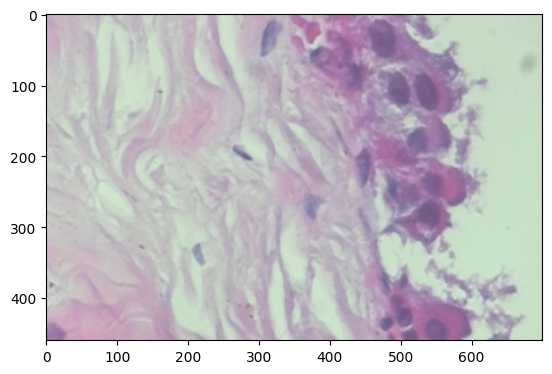

In [4]:
# Construct the full path to the image
from PIL import Image

# Open an image file
image_path = '/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png'
image = Image.open(image_path)

# Display the image if needed
plt.imshow(image)
# print(image.shape)

In [5]:
# Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE, RESIZE))
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:11<00:00, 31.75it/s]


In [6]:
# # Construct the full path to the image
# from PIL import Image

# # Open an image file
# image_path = '/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png'
# image = Image.open(image_path)

# # Display the image if needed
# plt.imshow(image)
# # print(image.shape)

#CREATE LABEL


In [7]:

#print label name
label =  {0:"benign", 1:"malignant"}
for i in label.keys() :
    print(i, label[i])


0 benign
1 malignant


In [8]:
# Breast Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

#VISUALIZE DATA


In [9]:
# #visualize data
# fig, axis = plt.subplots()
# axis.bar("test_data", 547, color='b', label='Test Data')
# axis.bar("train_data", 1148 , color='r', label='Train Data')
# legend = axis.legend()

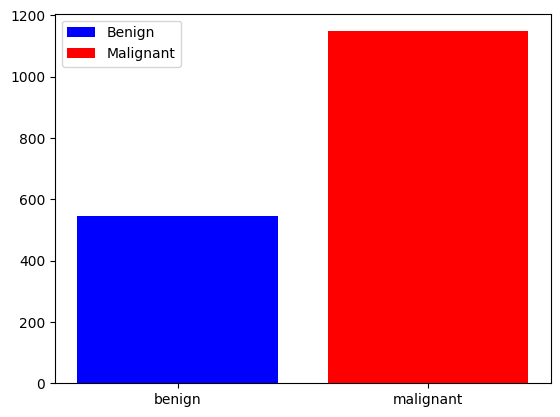

In [10]:
#visualize data
fig, axis = plt.subplots()
axis.bar("benign", 547, color='b', label='Benign')
axis.bar("malignant", 1148, color='r', label='Malignant')
legend = axis.legend()

#TRAIN AND EVALUATION SPLIT


In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

print("Shape of an Image in x_train",x_train[0].shape)
print("Shape of an Image in x_val", x_val[0].shape)

Shape of an Image in x_train (224, 224, 3)
Shape of an Image in x_val (224, 224, 3)


#DISPLAY IMAGES

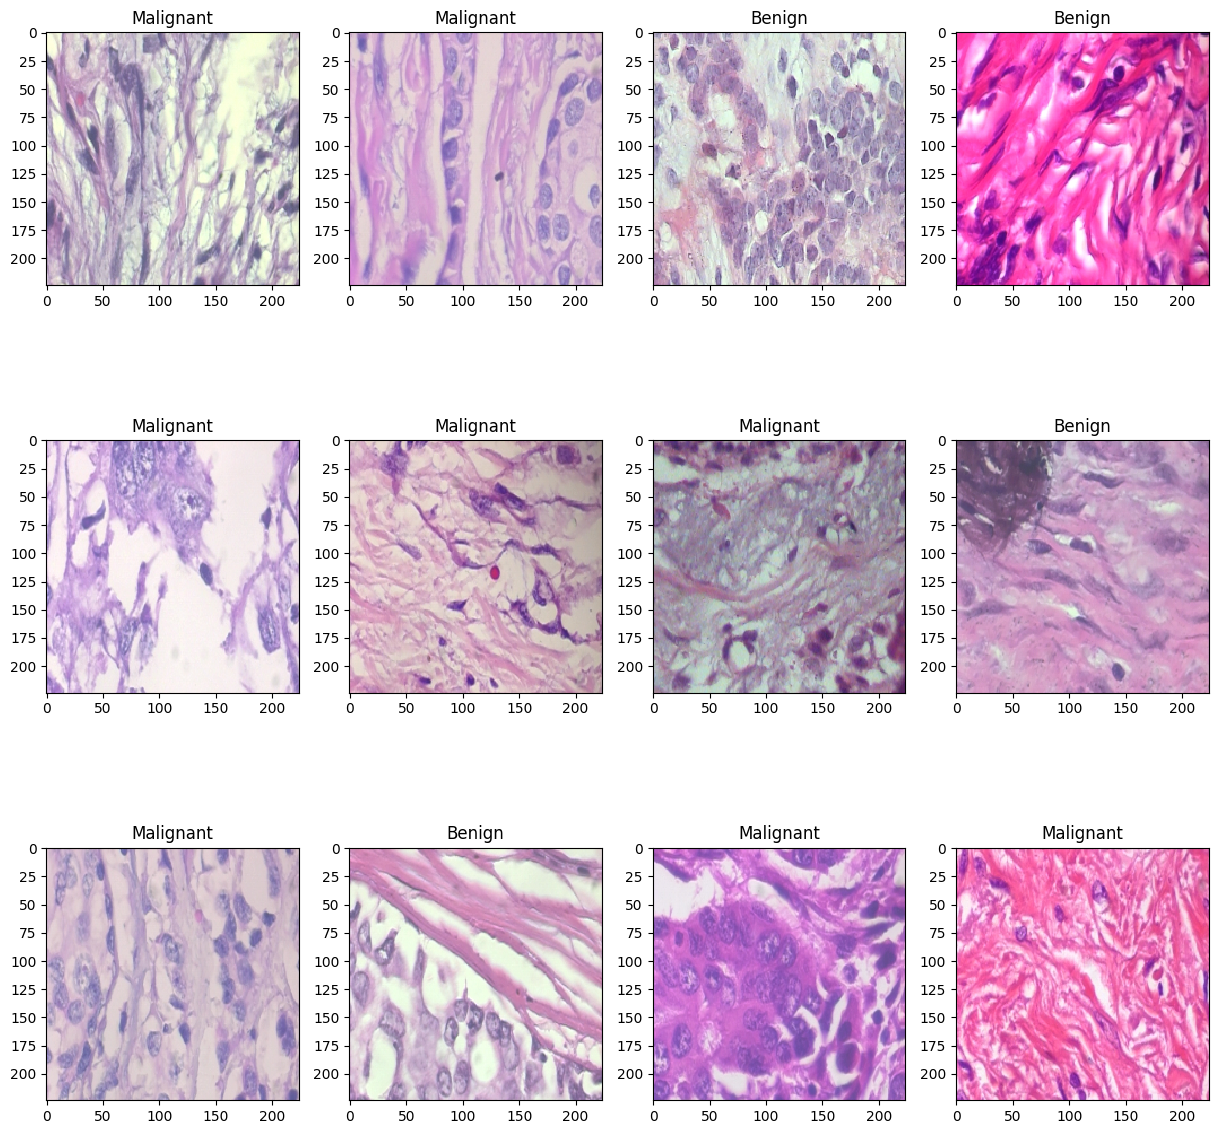

In [12]:
# # Display first 15 images of moles, and how they are classified
w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [13]:
# print(x_train.shape)
# print(x_val.shape)
# print(y_train.shape)
# print(y_val.shape)

#DATA GENERATOR

In [14]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

# train_gen = ImageDataGenerator(rescale=1./255,
#                                rotation_range = 20 ,
#                                horizontal_flip = True ,
#                                validation_split = 0.25
# )
# classes = ['Benign', 'Malignant']
# valid_gen = ImageDataGenerator(rescale=1./255,validation_split = 0.25)
# train_data = train_gen.flow_from_directory(X_train, subset='training', target_size=(224,224),
#                                            batch_size=64, color_mode='rgb',
#                                             class_mode='categorical', shuffle=True,classes=classes)

# test_data = valid_gen.flow_from_directory(X_val, subset='validation', target_size=(224,224),
#                                           batch_size=64, color_mode='rgb',
#                                             class_mode='categorical', shuffle=False,classes=classes)

#BUILDING THE MODEL 1

In [15]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


In [16]:
# model = Sequential()
# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


vvg = VGG16(input_shape=(224,224, 3), include_top=False,weights = 'imagenet')
for layers in (vvg.layers):
    layers.trainable = False

vvg.layers

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
# model.add(Flatten())
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense,Dropout
model = Sequential()
model.add(vvg)
# Add new layers
model.add(Flatten())
model.add(Dense(4096 , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096 , activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.summary()
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              1

In [18]:
# from keras.optimizers import Adam

model.compile(optimizer='Adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# lr = 1e-7
# model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [19]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor = 'accuracy', patience = 5,
                                  verbose = 1,factor = 0.2, min_lr = 1e-7)

# Checkpoint
filepath = "ModelVGG.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

#early stop  to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

#TRAINING AND EVALUATION


In [20]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size = BATCH_SIZE),
    steps_per_epoch = x_train.shape[0] / BATCH_SIZE,
    epochs = 150,
    validation_data = (x_val, y_val),
    callbacks=[learn_control, checkpoint]
)


Epoch 1/150
58/57 [==============================] - ETA: 0s - loss: 34.9515 - accuracy: 0.6133
Epoch 1: accuracy improved from -inf to 0.61329, saving model to ModelVGG.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 41s 569ms/step - loss: 34.9515 - accuracy: 0.6133 - val_loss: 2.3987 - val_accuracy: 0.6391 - lr: 0.0010
Epoch 2/150
58/57 [==============================] - ETA: 0s - loss: 2.5050 - accuracy: 0.6525
Epoch 2: accuracy improved from 0.61329 to 0.65251, saving model to ModelVGG.hdf5
57/57 [==============================] - 37s 655ms/step - loss: 2.5050 - accuracy: 0.6525 - val_loss: 1.9470 - val_accuracy: 0.3739 - lr: 0.0010
Epoch 3/150
58/57 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.6841
Epoch 3: accuracy improved from 0.65251 to 0.68410, saving model to ModelVGG.hdf5
57/57 [==============================] - 31s 552ms/step - loss: 1.1305 - accuracy: 0.6841 - val_loss: 0.5401 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 4/150
58/57 [==============================] - ETA: 0s - loss: 0.8488 - accuracy: 0.6961
Epoch 4: accuracy improved from 0.68410 to 0.69608, saving model to ModelVGG.hdf5
57/57 [==========================

In [21]:
#evaluate model
model.evaluate(x_val, y_val)

8/8 [==============================] - 1s 108ms/step - loss: 0.4305 - accuracy: 0.8217


[0.4305444061756134, 0.821739137172699]

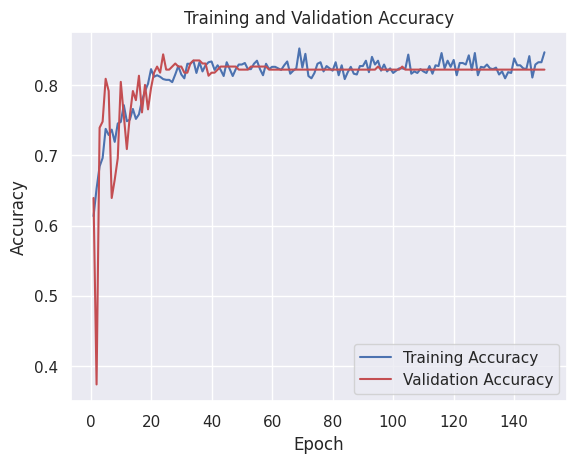

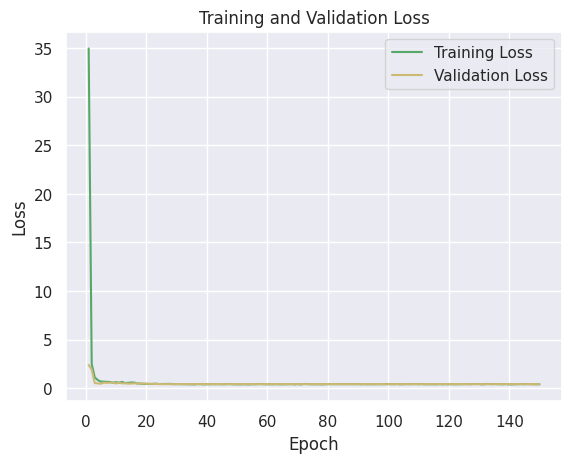

In [22]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, accuracy, color = 'b', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, color = 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

#loss plot
plt.figure()
plt.plot(epochs, loss, color = 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'y', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#PREDICTION

In [23]:
Y_pred = model.predict(X_test)
#Y_pred = np.argmax(Y_pred,axis=1)

18/18 [==============================] - 3s 174ms/step


In [24]:
Y_val_pred = model.predict(x_val)

8/8 [==============================] - 1s 113ms/step


In [25]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis = 1))

0.8217391304347826

In [26]:
tta_steps = 10
predictions = []
from tqdm import tqdm
for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

34/34 [==============================] - 8s 230ms/step


 10%|█         | 1/10 [00:08<01:16,  8.48s/it]

34/34 [==============================] - 7s 192ms/step


 20%|██        | 2/10 [00:15<01:01,  7.64s/it]

34/34 [==============================] - 8s 233ms/step


 30%|███       | 3/10 [00:24<00:56,  8.09s/it]

34/34 [==============================] - 7s 204ms/step


 40%|████      | 4/10 [00:31<00:47,  7.96s/it]

34/34 [==============================] - 7s 200ms/step


 50%|█████     | 5/10 [00:39<00:39,  7.94s/it]

34/34 [==============================] - 8s 235ms/step


 60%|██████    | 6/10 [00:48<00:32,  8.19s/it]

34/34 [==============================] - 6s 188ms/step


 70%|███████   | 7/10 [00:55<00:23,  7.85s/it]

34/34 [==============================] - 8s 237ms/step


 80%|████████  | 8/10 [01:04<00:16,  8.14s/it]

34/34 [==============================] - 8s 223ms/step


 90%|█████████ | 9/10 [01:15<00:09,  9.02s/it]

34/34 [==============================] - 7s 194ms/step


100%|██████████| 10/10 [01:22<00:00,  8.27s/it]


#CONFUSION MATRIX

In [27]:

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[110  66]
 [ 27 342]]


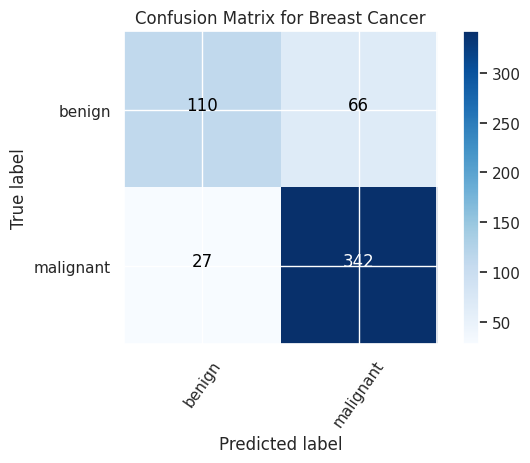

In [28]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Confusion Matrix for Breast Cancer')

Confusion matrix, without normalization
[[107  69]
 [ 20 349]]


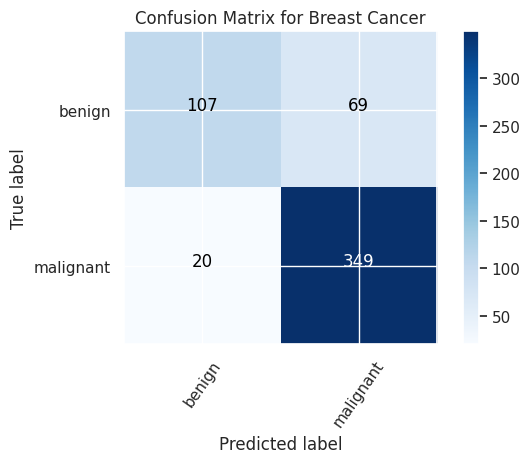

In [29]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Confusion Matrix for Breast Cancer')

#CLASSIFICATION REPORT

In [30]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.61      0.71       176
           1       0.83      0.95      0.89       369

    accuracy                           0.84       545
   macro avg       0.84      0.78      0.80       545
weighted avg       0.84      0.84      0.83       545



# ROC AND AUC

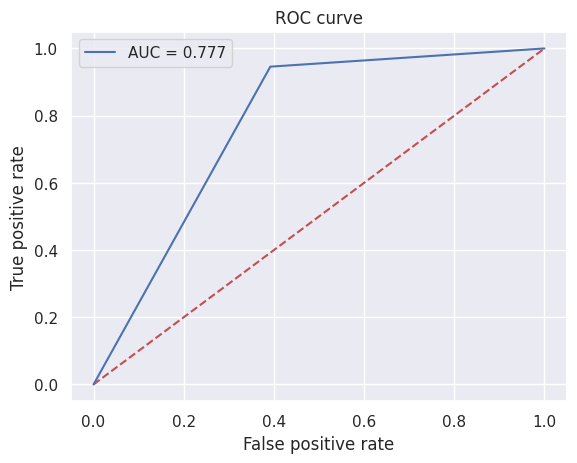

In [31]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

# DISPLAY SOME PREDICTIONS

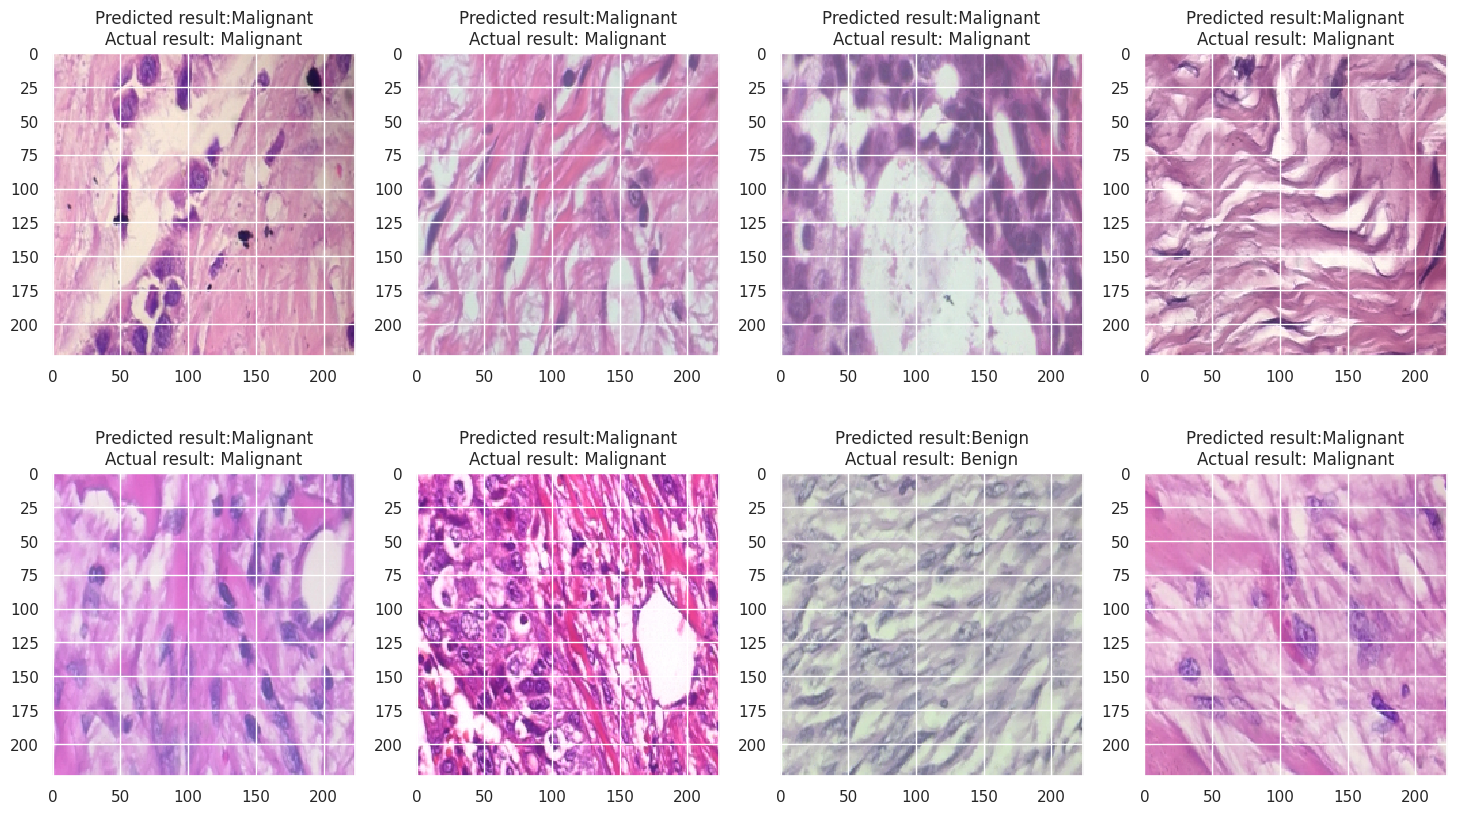

In [32]:
i = 0
prop_class = []
mis_class = []

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class) == 8):
        break

i = 0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class) == 8):
        break

# # Display first 8 images of benign
w = 60
h = 40
fig = plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

# SAMPLE TEST MODEL

1/1 [==============================] - 0s 27ms/step
[0]
benign


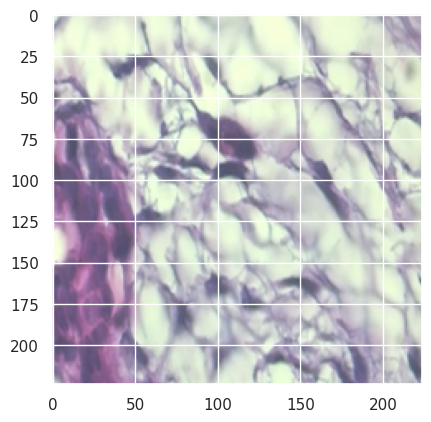

In [40]:
# model 1 test 1
from PIL import Image
import numpy as np

img_ = Image.open('/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_F-14-14134-400-002.png')
img_ = img_.resize((224,224))
imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)



1/1 [==============================] - 0s 20ms/step
[1]
malignant


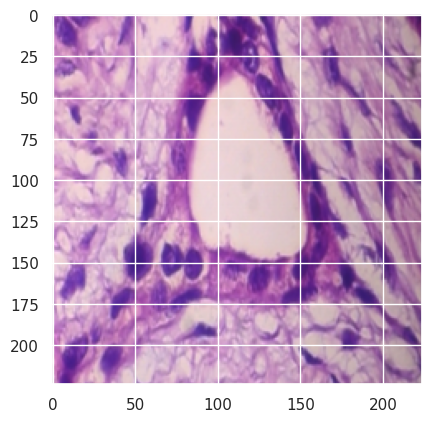

In [41]:
# model 1 test 1
from PIL import Image
import numpy as np

img_ = Image.open("/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_F-14-25197-400-059.png")
img_ = img_.resize((224,224))

imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)



1/1 [==============================] - 0s 27ms/step
[0]
benign


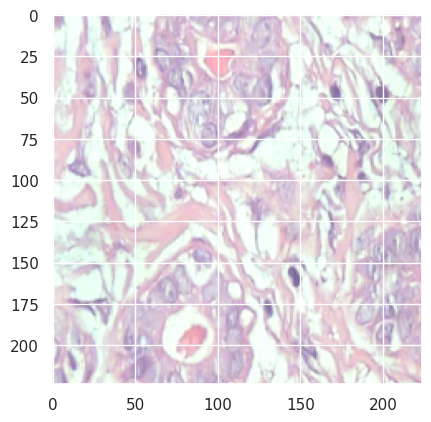

In [42]:
# model 1 test 1
from PIL import Image
import numpy as np

img_ = Image.open('/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-29960CD-400-009.png')
img_ = img_.resize((224,224))
imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)



1/1 [==============================] - 0s 21ms/step
[1]
malignant


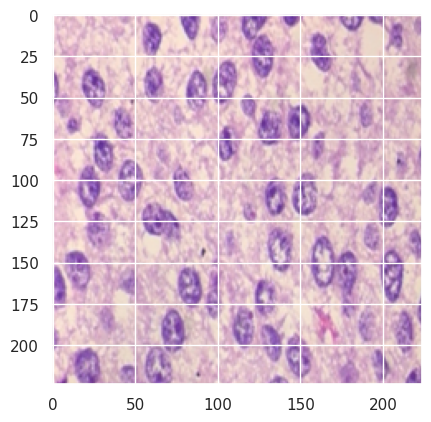

In [43]:
# model 1 test 1
from PIL import Image
import numpy as np

img_ = Image.open('/content/drive/MyDrive/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-007.png')
img_ = img_.resize((224,224))

imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

